In [3]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)



In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy
import itertools
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
from neuromancer.loggers import BasicLogger

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model


# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
integrator_node = Node(integrator, ['xn', 'u'], ['xn'], name='model')


In [6]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader

nsteps = 10  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

dx0/dt = 0.496*x_0 + 0.088*x_1 + 0.307*sin(x_0) + 0.490*sin(x_1) + 0.456*x_0 * x_1 + 0.349*r_0 + 0.022*r_1 + 0.294*r_0^2 + 0.698*r_1^2 + 0.161*x_0 * r_0 + 0.682*x_0 * r_1 + 0.397*x_1 * r_0 + 0.419*x_1 * r_1 
dx1/dt = 0.768*x_0 + 0.132*x_1 + 0.634*sin(x_0) + 0.896*sin(x_1) + 0.632*x_0 * x_1 + 0.402*r_0 + 0.169*r_1 + 0.519*r_0^2 + 0.800*r_1^2 + 0.282*x_0 * r_0 + 0.915*x_0 * r_1 + 0.874*x_1 * r_0 + 0.553*x_1 * r_1 



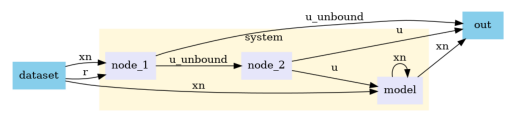

In [7]:
from library import FunctionLibrary
torch.manual_seed(0)
# Number of features and control variables
n_features = nx
n_controls = nu

# Create an empty list for features and names
theta_funs = []
theta_names = []

# Degree 1 features (x_i)
theta_funs += [(lambda X, u, i=i: X[:, i]) for i in range(n_features)]
theta_names += [f"x_{i}" for i in range(n_features)]

# Sinusoidal features (sin(x_i))
theta_funs += [(lambda X, u, i=i: torch.sin(X[:, i])) for i in range(n_features)]
theta_names += [f"sin(x_{i})" for i in range(n_features)]

# # Product of x_i and sin(x_i)
# theta_funs += [(lambda X, u, i=i: X[:, i] * torch.sin(X[:, i])) for i in range(n_features)]
# theta_names += [f"x_{i} * sin(x_{i})" for i in range(n_features)]

#Quadratic interaction terms (x_i * x_j)
for i, j in itertools.combinations(range(n_features), 2):
    theta_funs.append(lambda X, u, i=i, j=j: X[:, i] * X[:, j])
    theta_names.append(f"x_{i} * x_{j}")


# Control inputs (u_i)
theta_funs += [(lambda X, u, i=i: u[:, i]) for i in range(n_controls)]
theta_names += [f"r_{i}" for i in range(n_controls)]

# Squared control inputs (u_i^2)
theta_funs += [(lambda X, u, i=i: u[:, i] ** 2) for i in range(n_controls)]
theta_names += [f"r_{i}^2" for i in range(n_controls)]

# Interaction terms (x_i * u_j)
theta_funs += [(lambda X, u, i=i, j=j: X[:, i] * u[:, j]) for i in range(n_features) for j in range(n_controls)]
theta_names += [f"x_{i} * r_{j}" for i in range(n_features) for j in range(n_controls)]

# Create function library
theta_library = FunctionLibrary(theta_funs, n_features, n_controls, theta_names)


# Create SINDy model
policy_sindy = sindy.SINDy(theta_library)
print(policy_sindy)

sindy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'])
u_bound = Node(lambda u: torch.sigmoid(u) * (umax-umin) + umin, ['u_unbound'], ['u'])

sindy_system = System([sindy_node, u_bound, integrator_node], nsteps=nsteps)
sindy_system.show()

In [8]:
# torch.manual_seed(0)
# max_freq = 5
# max_degree = 2
#
# theta_1 = library.FourierLibrary(nx, nref, max_freq=max_freq)
# theta_2 = library.PolynomialLibrary(nx, nref, max_degree=max_degree)
# policy_sindy = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))
# sindy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'])
# u_bound = Node(lambda u: torch.sigmoid(u) * (umax-umin) + umin, ['u_unbound'], ['u'])
#
# sindy_system = System([sindy_node, u_bound, integrator_node], nsteps=nsteps)
# sindy_system.show()

In [9]:
print(policy_sindy)

dx0/dt = 0.496*x_0 + 0.088*x_1 + 0.307*sin(x_0) + 0.490*sin(x_1) + 0.456*x_0 * x_1 + 0.349*r_0 + 0.022*r_1 + 0.294*r_0^2 + 0.698*r_1^2 + 0.161*x_0 * r_0 + 0.682*x_0 * r_1 + 0.397*x_1 * r_0 + 0.419*x_1 * r_1 
dx1/dt = 0.768*x_0 + 0.132*x_1 + 0.634*sin(x_0) + 0.896*sin(x_1) + 0.632*x_0 * x_1 + 0.402*r_0 + 0.169*r_1 + 0.519*r_0^2 + 0.800*r_1^2 + 0.282*x_0 * r_0 + 0.915*x_0 * r_1 + 0.874*x_1 * r_0 + 0.553*x_1 * r_1 



In [10]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion

#sparsity
l1 = variable([x], lambda y: torch.norm(list(sindy_system.parameters())[0], p=1))
loss_l1 = 0.001*(l1 == 0)

# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss, loss_l1]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]



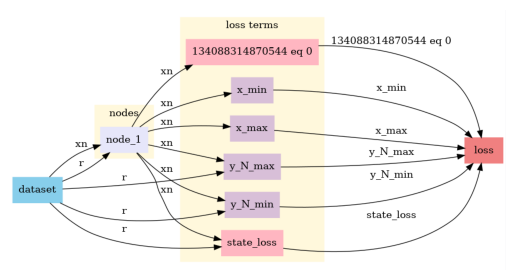

In [11]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [12]:
optimizer = torch.optim.AdamW(policy_sindy.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 26


In [35]:
for _ in range(5):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps += 10
    sindy_system.nsteps = nsteps
    trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 4.77006	dev_loss: 5.30140	eltime:  0.64431
epoch: 1	train_loss: 3.96924	dev_loss: 4.52897	eltime:  1.19593
epoch: 2	train_loss: 3.52757	dev_loss: 4.05406	eltime:  1.72424
epoch: 3	train_loss: 3.28240	dev_loss: 3.76540	eltime:  2.24274
epoch: 4	train_loss: 3.08467	dev_loss: 3.50988	eltime:  2.84360
epoch: 5	train_loss: 3.00106	dev_loss: 3.35706	eltime:  3.67577
epoch: 6	train_loss: 2.89906	dev_loss: 3.24656	eltime:  4.39143
epoch: 7	train_loss: 2.78765	dev_loss: 3.14763	eltime:  4.97820
epoch: 8	train_loss: 2.69789	dev_loss: 3.06439	eltime:  5.47596
epoch: 9	train_loss: 2.62630	dev_loss: 2.99251	eltime:  6.04402
epoch: 10	train_loss: 2.56337	dev_loss: 2.93028	eltime:  6.61303
epoch: 11	train_loss: 2.50727	dev_loss: 2.87584	eltime:  7.16090
epoch: 12	train_loss: 2.45850	dev_loss: 2.82820	eltime:  7.71810
epoch: 13	train_loss: 2.41555	dev_loss: 2.78647	eltime:  8.30448
epoch: 14	train_loss: 2.37714	dev_loss: 2.74

In [75]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_policy_SINDY_WB_Model_" + "_".join(policy_sindy.library.function_names) + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)

# # Save the model state dictionary
# torch.save(policy_sindy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy_SINDY_WB_Model_x_0_x_1_sin(x_0)_sin(x_1)_x_0 * x_1_r_0_r_1_r_0^2_r_1^2_x_0 * r_0_x_0 * r_1_x_1 * r_0_x_1 * r_1_20250312_100917.pth


In [13]:
import glob

# Define directory
save_dir = "saved_models"

# Find the latest saved model (optional, if multiple exist)
model_files = sorted(glob.glob(os.path.join(save_dir, "pt_policy_SINDY_WB_Model_*.pth")), reverse=True)
if not model_files:
    raise FileNotFoundError("No saved model files found in the directory.")

latest_model_path = model_files[0]  # Select the most recent one

# Load the state dictionary into the model
policy_sindy.load_state_dict(torch.load(latest_model_path))

print(f"Model loaded from {latest_model_path}")


Model loaded from saved_models/pt_policy_SINDY_WB_Model_x_0_x_1_sin(x_0)_sin(x_1)_x_0 * x_1_r_0_r_1_r_0^2_r_1^2_x_0 * r_0_x_0 * r_1_x_1 * r_0_x_1 * r_1_20250312_100917.pth


In [14]:
nsteps = 750
torch.manual_seed(0)
seed = 20
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

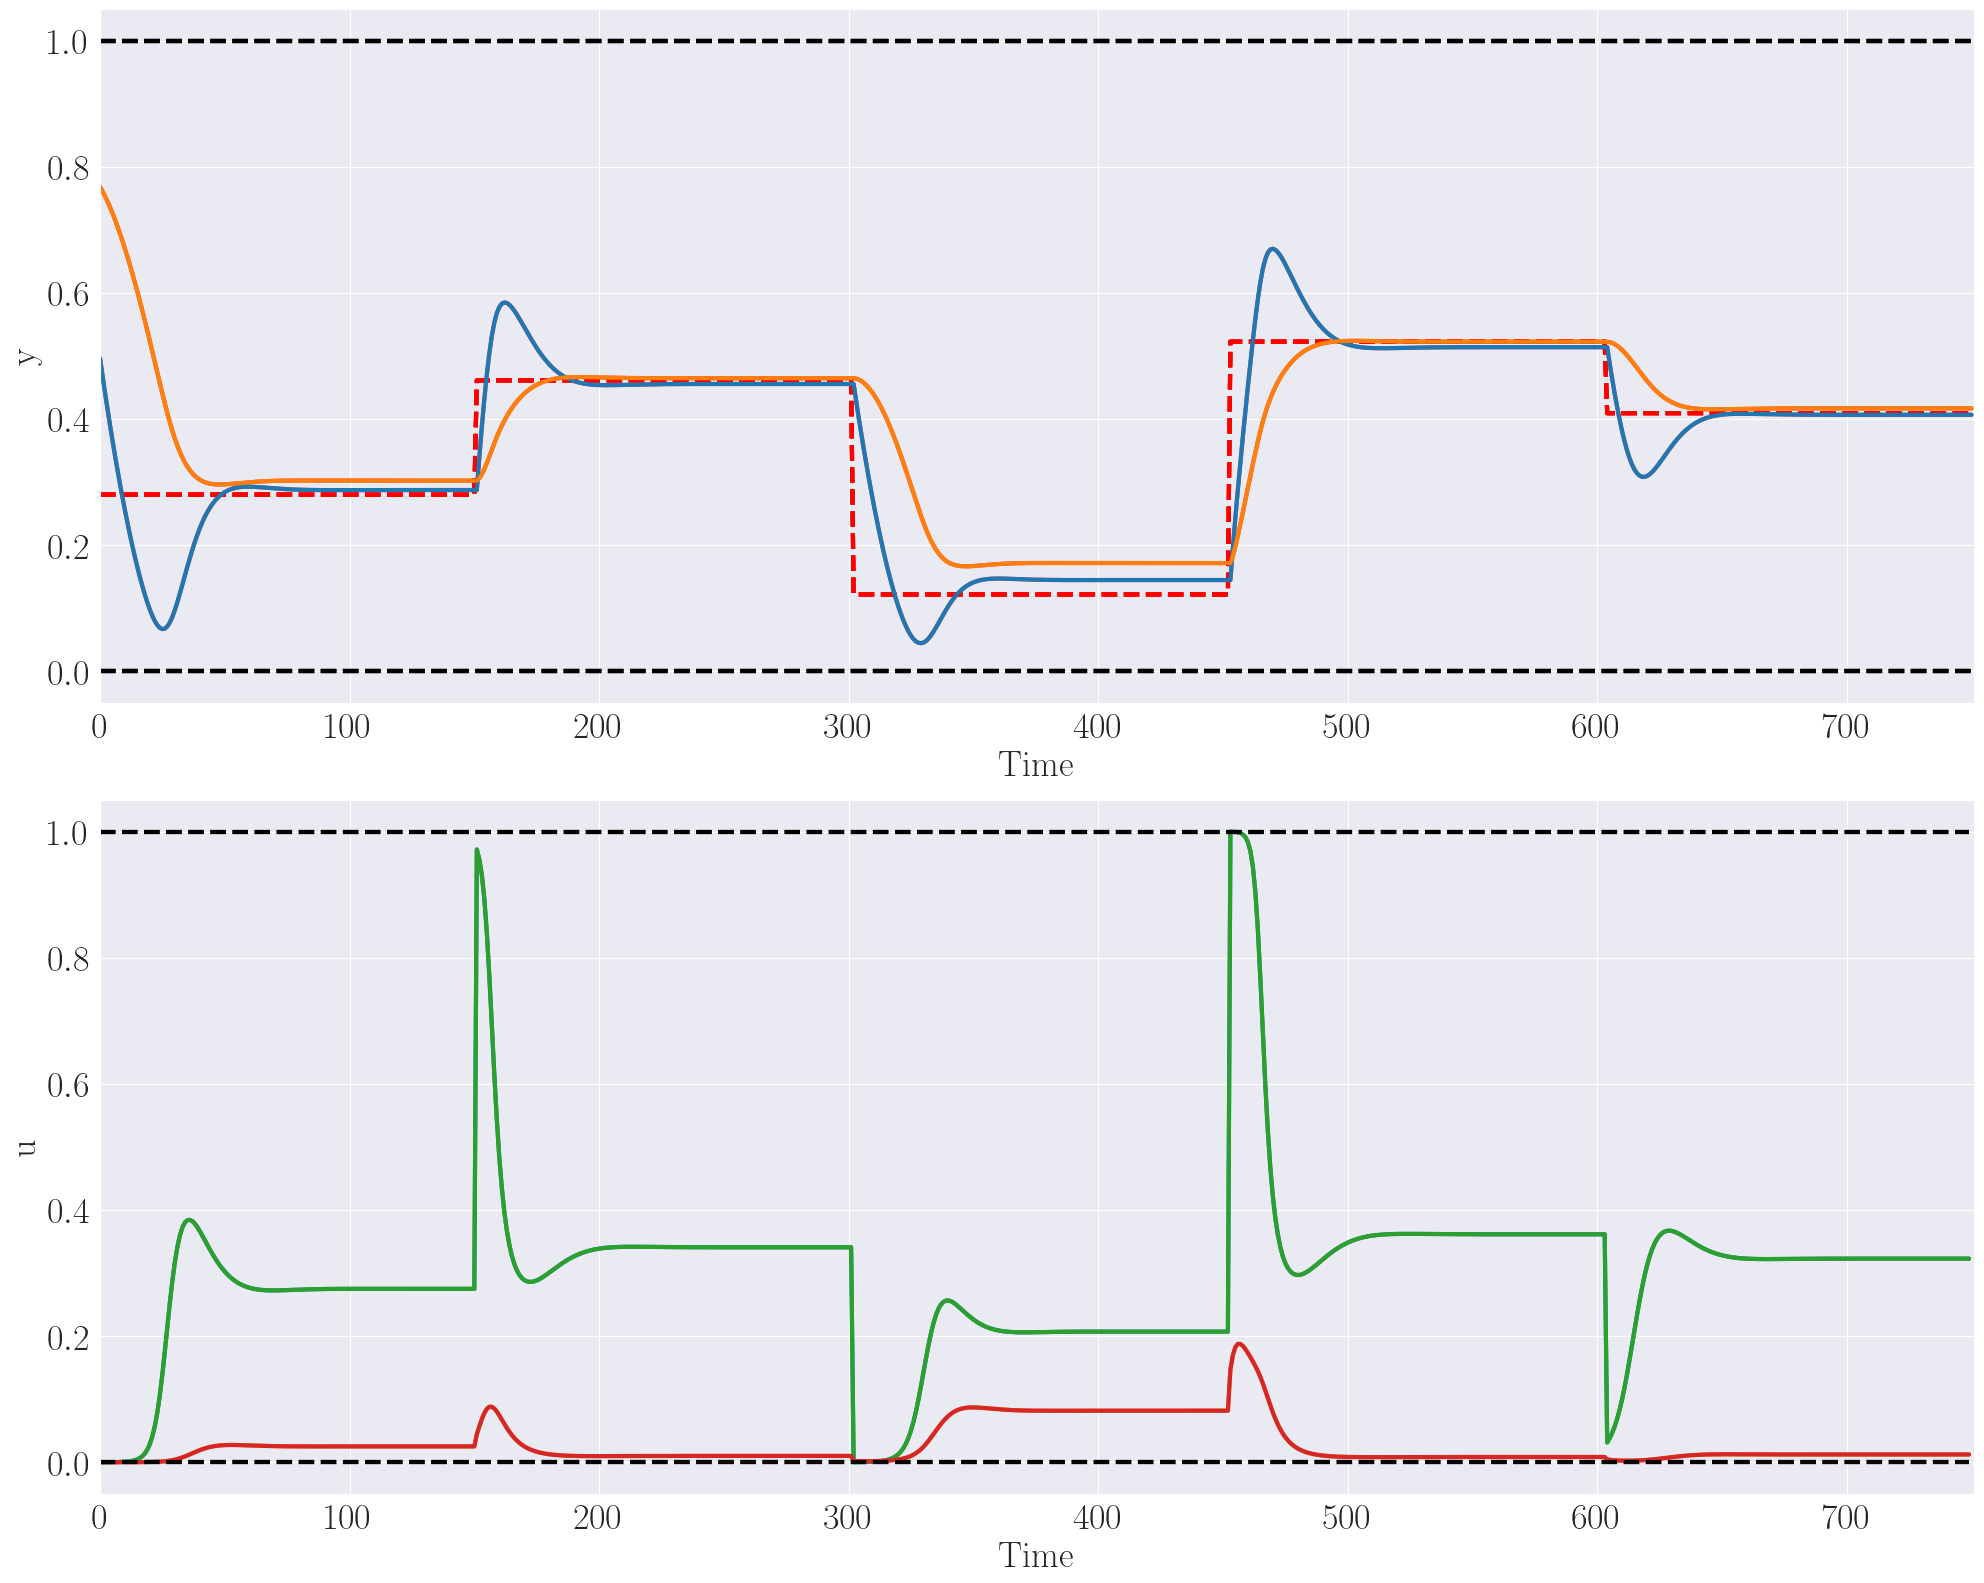

In [15]:
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1, requires_grad=False))
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2, requires_grad=False))
500
sindy_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = sindy_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

In [78]:
print(policy_sindy)


dx0/dt = -7.130*x_0 + -11.419*x_1 + -6.990*sin(x_1) + -0.450*x_0 * x_1 + 11.590*r_0 + 11.588*r_1 + 1.218*r_0^2 + 1.220*r_1^2 + -0.215*x_0 * r_0 + -0.215*x_0 * r_1 
dx1/dt = 1.016*x_0 + -11.646*x_1 + -4.505*sin(x_1) + 0.014*r_1^2 + 5.603*x_0 * r_0 + 5.606*x_0 * r_1 



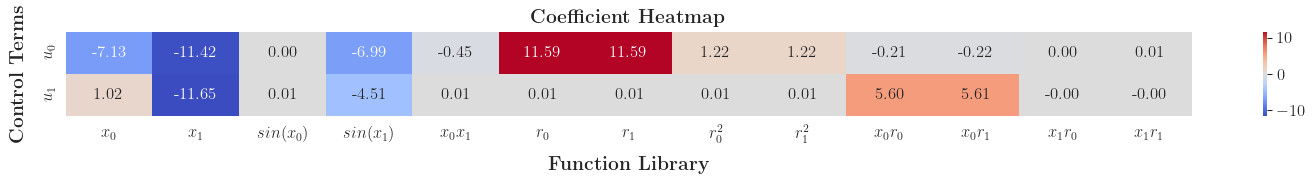

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = policy_sindy.coef.data.numpy()

def convert_to_latex(names):
    return [rf"${i.replace('*', ' ').replace('  ', ' ')}$" for i in names]
function_names_latex = convert_to_latex(policy_sindy.library.function_names)

control_terms_latex = [r"$u_0$", r"$u_1$"]



plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(coefficients.T, annot=True, xticklabels=function_names_latex, yticklabels=control_terms_latex, cmap="coolwarm", fmt=".2f", ax=ax)

ax.set_ylabel(r"\textbf{Control Terms}", fontsize=14, labelpad=10)
ax.set_xlabel(r"\textbf{Function Library}", fontsize=14, labelpad=10)
ax.set_title(r"\textbf{Coefficient Heatmap}", fontsize=14)

ax.xaxis.tick_top()  # Move x-axis ticks to the top first
ax.xaxis.set_label_position('bottom')  # Move label to the bottom
ax.tick_params(axis='x', bottom=False, top=False, labelbottom=True, labeltop=False)  # Enable bottom ticks, disable top
plt.xticks(rotation=0, ha='center')  # Keep x-axis labels horizontal

plt.tight_layout()
plt.show()
